Files already downloaded and verified
Files already downloaded and verified
400
Accuracy of CNN: 56.0 %
Acuuracy of plane:56.7%
Acuuracy of car:73.2%
Acuuracy of bird:42.8%
Acuuracy of cat:30.9%
Acuuracy of deer:39.4%
Acuuracy of dog:46.0%
Acuuracy of frog:72.2%
Acuuracy of horse:68.6%
Acuuracy of ship:60.1%
Acuuracy of truck:70.1%


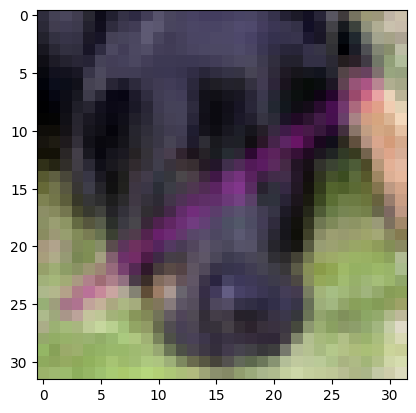

Predicted label: 7
Actual label: 5


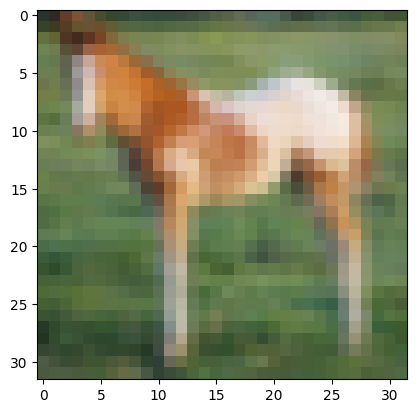

Predicted label: 7
Actual label: 7


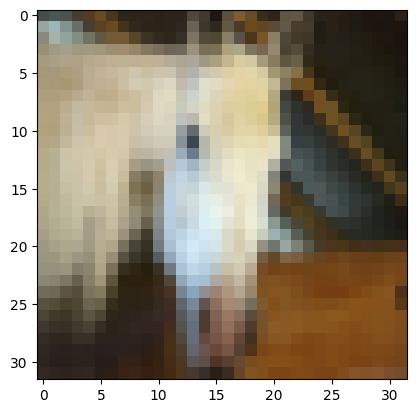

Predicted label: 5
Actual label: 7


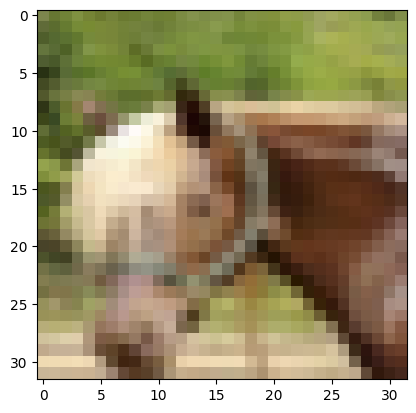

Predicted label: 7
Actual label: 7


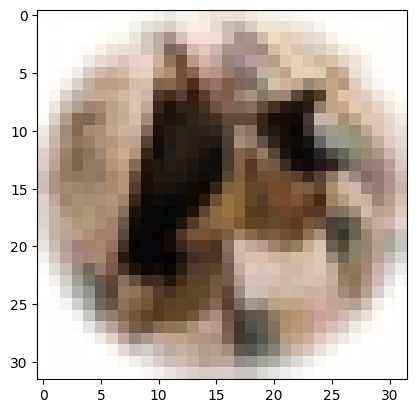

Predicted label: 3
Actual label: 3


In [4]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F 
import torchvision
from torchvision import transforms
import matplotlib.pyplot as plt
import torch.optim as optim 

#Device configuration
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

#Hyperparameters
num_epochs=20
batch_size=100
lr=0.4
#dataset has PILImage images of range[0,1]
#we transform them to Tensors of normalized range [-1,1]
transform = transforms.Compose([transforms.ToTensor(),transforms.Normalize((0.5,0.5,0.5),(0.5,0.5,0.5))])

#loading data
train= torchvision.datasets.CIFAR10(root='./data', download=True, train= True, transform=transform)
test= torchvision.datasets.CIFAR10(root='./data', train= False, download= True, transform=transform)

trainset= torch.utils.data.DataLoader(train, batch_size=batch_size, shuffle= True)
testset= torch.utils.data.DataLoader(test, batch_size=batch_size, shuffle=True)

classes=('plane','car','bird','cat','deer','dog','frog','horse','ship','truck')

def imshow(img):
    img=img /2+0.5 #unnormalize
    npimg=img.numpy()
    plt.imshow(np.transpose(npimg,(1,2,0)))
    plt.show()

#getting some random training images
dataiter=iter(trainset)
images, labels= dataiter.__next__()

#Building a CNN
class ConvNet(nn.Module):
    def __init__(self):
        super().__init__()
        #images are coloured so now input channel has 3 channels, output channel size say 6 and kernel size=5
        self.conv1=nn.Conv2d(3,6,5)
        self.conv2=nn.Conv2d(6,16,5)

        #print(images.shape) to get size of each image

        x=torch.randn(3,32,32).view(-1,3,32,32)#to check output of final convolutional layer take x as some random matrix of same size as any of our imput image
        self._to_linear=None
        self.convs(x)

        self.fc1=nn.Linear(self._to_linear,128)
        self.fc2=nn.Linear(128,64)
        self.fc3=nn.Linear(64,10) #final output is a class of 10 digits

    def convs(self,x):
        x=F.max_pool2d(F.relu(self.conv1(x)),(2,2))#kernel size is 2*2 and stride is 2
        x=F.max_pool2d(F.relu(self.conv2(x)),(2,2))#kernel size is 2*2 and stride is 2
        if self._to_linear is None:
            self._to_linear=x[0].shape[0]*x[0].shape[1]*x[0].shape[2]
            print(self._to_linear)
        return x
    
    def forward(self,x):
        x=self.convs(x)
        x=x.view(-1,self._to_linear)
        x=F.relu(self.fc1(x))
        x=F.relu(self.fc2(x))
        x=self.fc3(x)
        return x #no need of softmax function here as we will use CrossEntropyLoss which already includes the softmax
    
net=ConvNet()

optimizer= optim.SGD(net.parameters(), lr=lr)
loss_function=nn.CrossEntropyLoss()
n=len(trainset)
for epoch in range(num_epochs):
    for i, (images,labels) in enumerate(trainset):
        #forward pass
        output= net(images)
        loss=loss_function(output,labels)

        #back-propagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

with torch.no_grad():
    correct = 0
    total = 0
    class_correct=[0 for i in range(10)]
    class_total=[0 for i in range(10)]
    for data in testset:
        images,labels=data
        outputs = net(images)
        _, predicted= torch.max(outputs,1)
        total+=labels.size(0)
        correct+= (predicted==labels).sum().item()

        for i in range(batch_size):
            label=labels[i].item()
            pred=predicted[i].item()
            if(label == pred):
                class_correct[label]+=1
            class_total[label]+=1


            
print(f'Accuracy of CNN: {round(correct/total*100,3)} %')

for i in range(10):
    acc=100.0*class_correct[i]/class_total[i]
    print(f'Acuuracy of {classes[i]}:{acc}%')


for i in range(5):
    #show images of a batch of batch_size
    imshow(torchvision.utils.make_grid(images[i]))
    print(f'Predicted label: {torch.argmax(net(images[i].view(-1,32,32)))}')
    print(f'Actual label: {labels[i]}')
